# **Facial Emotion Detection**






## **Scoring guide (Rubric) - Milestone Submission - Facial Emotion Detection**

[Problem Definition](#problem-definition)

[Data Exploration](#data-exploration)

**Refined Insights**
  - [Behaviour of CNN model on image data](#cnn)
  - [Distribition of classes and their distinguishing features](#creating-data-loaders)
  - [Behaviour of the two colorscales, and which one performs better](#evaluating-the-base-neural-network)
  - [Behaviour of Transfer Learning models](#transfer-learning)
  - [Does transfer learning help to improve the model performance? Reasoning for building our own complex CNN Architecture](#model-summary)

**Comparison of various techniques and their relative performance**
  - [Comparison of the working models' performance on the test data](#evaluating-the-base-neural-network)
  - [Comparing the Transfer Learning models' performance and giving the reason for their poor performance](#model-summary)
  - [Printing the classification report and plotting the confusion matrix for the final chosen model](#evaluating-the-complex-neural-network)
  - [Is there is a scope to improve the performance further? If yes, how?](#complex-neural-network-observations)

[Proposal for the final solution design](#final-model)

## **Scoring guide (Rubric) - Final Submission - Facial Emotion Detection**

- [Executive summary](#executive-summary)

- [Problem and solution summary](#problem-and-solution-summary)
	
- [Recommendations for implementation](#recommendations-for-implementation)

<a name="problem-definition"></a>
## **Problem Definition**

**The context:** Why is this problem important to solve?<br>

Facial emotion detection could help create more emotionally intelligent machines, which could improve human-machine interactions in a variety of settings. For example, detection of mental disorders, and creating a higher quality of virtual assistant for
customer-facing businesses.

**The objectives:** What is the intended goal?<br>

Create a deep learning model that can classify multiple classes of facial expressions based on associated emotions.

**The key questions:** What are the key questions that need to be answered?<br>

- The most effective algorithms and techniques for recognizing and classifying emotions
- How to train and validate the algorithms
- How to address bias and fairness in facial emotion detection
- How to improve the accuracy and performance of facial emotion detection system

**The problem formulation:** What are we trying to solve using data science?

Analyze and develop models based on facial features such as the position of the eyebrows, the shape of the mouth, and wrinkles around the eyes.


## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


### **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing the Libraries**

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load and unzip the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

<a name="data-exploration"></a>

## **Data Exploration**

- [Key patterns](#key-patterns)
  - Relationship between facial expressions and different emotional
    - Mouthing
    - Eyebrows
    - Cheek

  - Important for computer algorithms and machine learning models developed

  - Accurately recognize and classify emotions from facial expressions

- [Data distribution](#data-distribution)
    - Affect the performance of the model
    - Unbalanced data can lead to biased or inaccurate models

    - Balance the classes
      - data augmentation to generate more training examples

- Other useful EDA tasks provide meaningful insights
  - [Visualization of image statistics](#visualization-of-image-statistics)


In [ ]:
img_size = 48
folder_path = "Facial_emotion_images/"

In [ ]:
# visualizing training data function
def display_training_data_img(expression):
  plt.figure(figsize= (5,5))
  for i in range(1, 10, 1):
      plt.subplot(3, 3, i)

      img = load_img(folder_path + "train/" + expression + "/" +
                    os.listdir(folder_path + "train/" + expression)[i], target_size = (img_size, img_size))
      plt.imshow(img)   

  plt.show()

<a name="key-patterns"></a>
#### **Key patterns**

- Patterns in different facial expressions 
    - [Happy](#happy)
    - [Sad](#sad)
    - [Neutral](#neutral)
    - [Surprised](#surprised)

<a name="happy"></a>
##### **Happy**

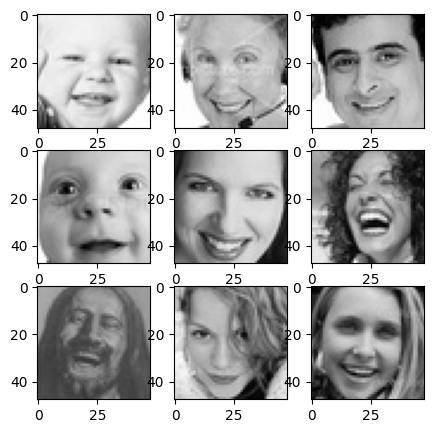

In [ ]:
display_training_data_img('happy')

**Observations and Insights:**
- Smiling mouth is one of the most common patterns. The corners of the mouth are turn up and upper teeth may be slightly visible

- The cheek raised and wrinkles around the cheek

- The eyebrows slightly raised

<a name="sad"></a>
##### **Sad**

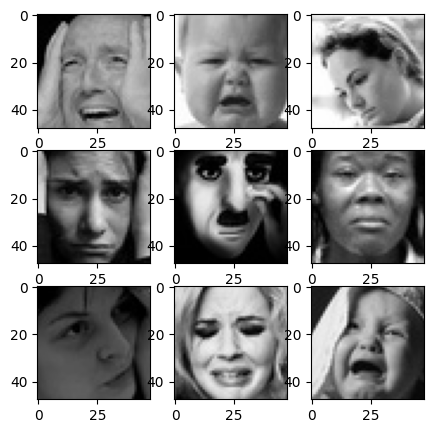

In [ ]:
display_training_data_img('sad')

**Observations and Insights:**
- Furrowed eyebrows is one of the most common patterns. The eyebrows are often pulled down and together

- The eyelids may be slightly drooping or lowered

- The corners of the mouth are turned down and the lower lip may be slightly drooping

- There may be a loss of symmetry between the left and right sides of the face. This can be seen in the position of the mouth, eyebrows

<a name="neutral"></a>
##### **Neutral**

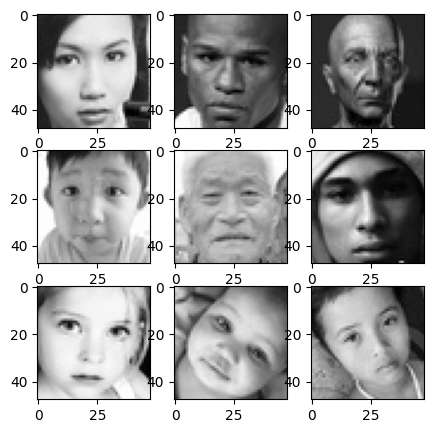

In [ ]:
display_training_data_img('neutral')

**Observations and Insights:**
- The face is generally symmetrical, with both sides of the face showing similar muscle activity

- Relaxed facial muscles, no particular tension or activity in any specific area

- The mouth is closed, with the lips pressed together

<a name="surprise"></a>
##### **Surprised**

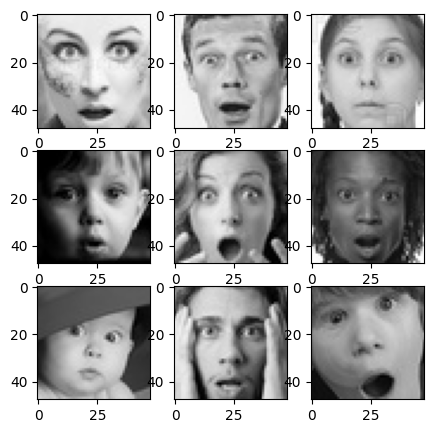

In [ ]:
display_training_data_img('surprise')

**Observations and Insights:**
- Raised eyebrows is one of the most common patterns.The eyebrows are raised and pulled up towards the hairline

- The eyes are widened, with the whites of the eyes more visible

- the mouth is slightly opened, create a more round or oval shape

<a name="data-distribution"></a>
#### **Data distribution**

In [ ]:
def plot_distribution(data_type):
    # Getting count of images in each folder within our training path
    num_happy = len(os.listdir(folder_path + data_type + "/happy"))
    print("Number of images in the class 'happy':   ", num_happy)

    num_sad = len(os.listdir(folder_path + data_type + "/sad"))
    print("Number of images in the class 'sad':   ", num_sad)

    num_neutral = len(os.listdir(folder_path + data_type + "/neutral"))
    print("Number of images in the class 'neutral':   ", num_neutral)

    num_surprise = len(os.listdir(folder_path + data_type + "/surprise"))
    print("Number of images in the class 'surprise':   ", num_surprise)
    
    # plot distribution
    plt.figure(figsize = (8, 5))

    data = {'Happy': num_happy, 'Sad': num_sad, 'Neutral': num_neutral, 'Surprise' : num_surprise}

    df = pd.Series(data)

    plt.bar(range(len(df)), df.values, align = 'center')

    plt.xticks(range(len(df)), df.index.values, size = 'small')

    plt.show()

Training data distribution
Number of images in the class 'happy':    3976
Number of images in the class 'sad':    3982
Number of images in the class 'neutral':    3978
Number of images in the class 'surprise':    3173


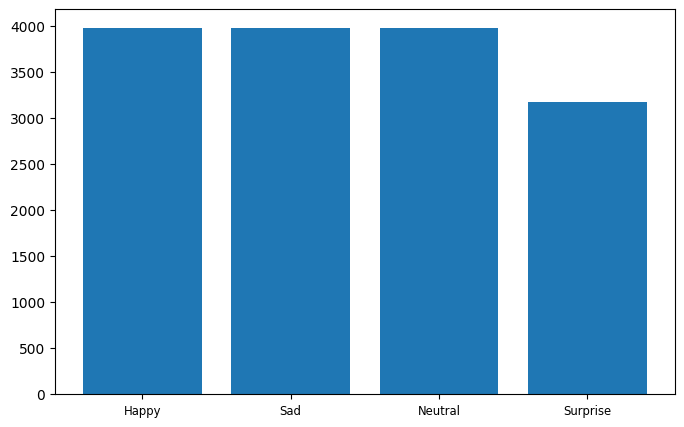

In [ ]:
print("Training data distribution")

# plot distribution
plot_distribution('train')

Validation data distribution
Number of images in the class 'happy':    1825
Number of images in the class 'sad':    1139
Number of images in the class 'neutral':    1216
Number of images in the class 'surprise':    797


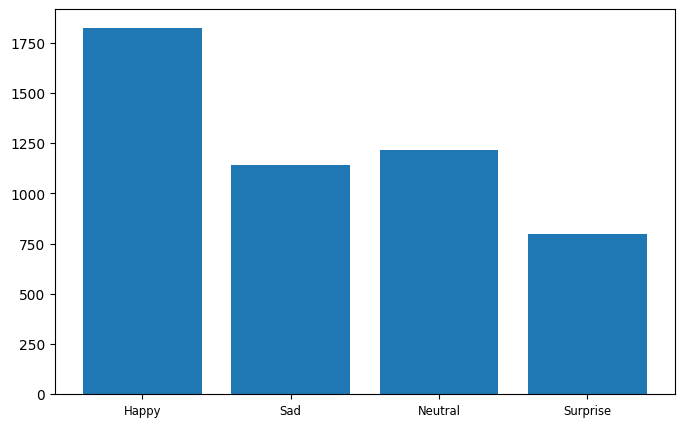

In [ ]:
# Getting count of images in each folder within our validation path
print("Validation data distribution")

# plot distribution
plot_distribution('validation')

Testing data distribution
Number of images in the class 'happy':    32
Number of images in the class 'sad':    32
Number of images in the class 'neutral':    32
Number of images in the class 'surprise':    32


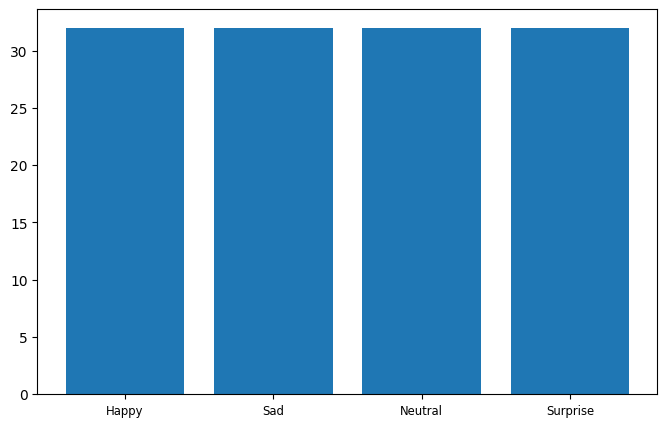

In [ ]:
# Getting count of images in each folder within our testing path
print("Testing data distribution")

# plot distribution
plot_distribution('test')

<a name="distribution-of-class"></a>
**Observations and Insights:**

- The suprise class in training data contains a smaller proportion of images compared to other classes
- The class distribution in validation data is not as balanced as the training data distribution
- Class 'sad' and 'surprise' significantly fewer images compared to other classes
- The class distribution in balanced, each class having the same number of images

**Think About It:** 
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

<a name="visualization-of-image-statistics"></a>
#### **Visualization of image statistics**

- mean
    - overall brightness

- standard deviation
    - contrast

- pixel intensity distribution
    - 0(black) - 255(white)
    - contrast and brightness of individuval pixel

- useful for normalizing the data prior to training a machine learning model.
- detecting outliers or anomalies in the image properties

<Figure size 300x300 with 0 Axes>

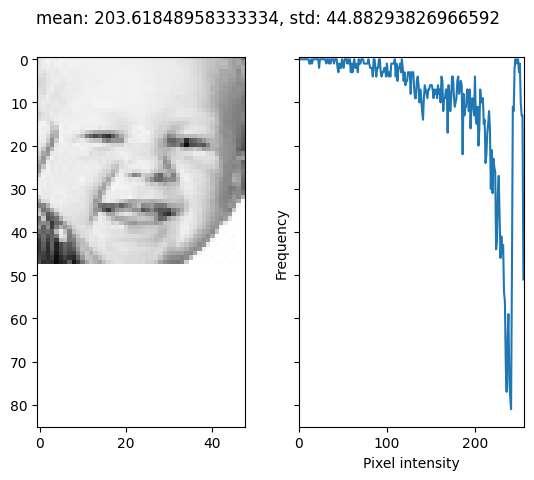

<Figure size 300x300 with 0 Axes>

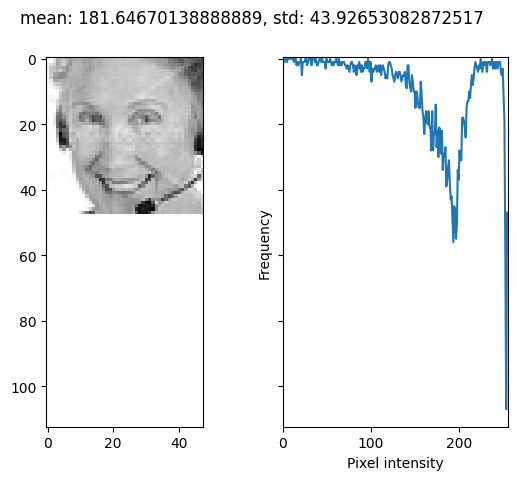

<Figure size 300x300 with 0 Axes>

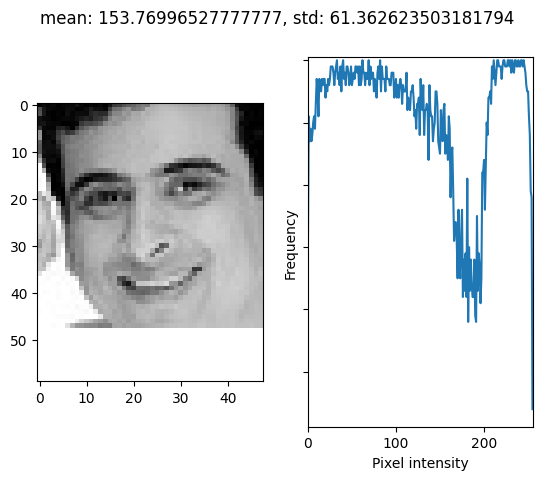

<Figure size 300x300 with 0 Axes>

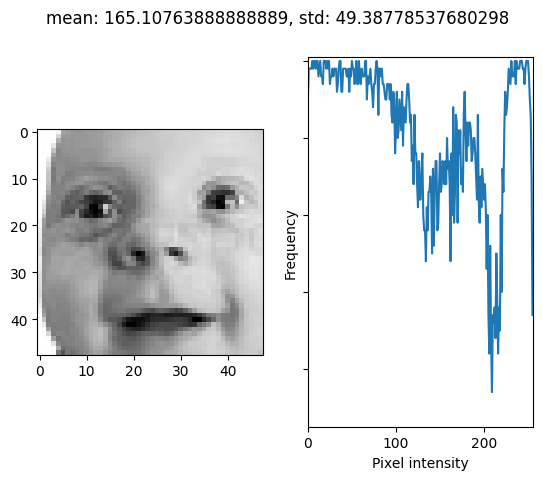

<Figure size 300x300 with 0 Axes>

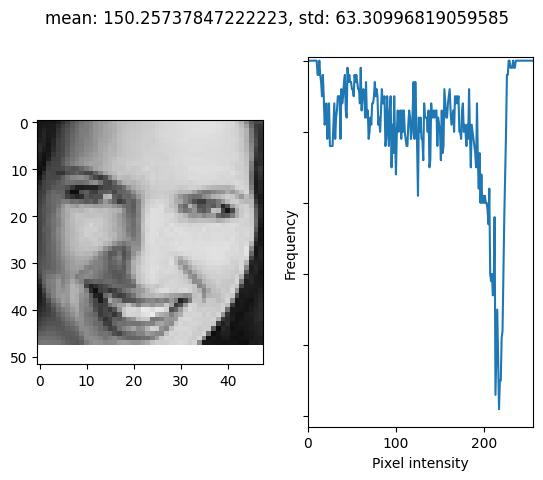

In [ ]:
for i in range(1, 6, 1):
    plt.figure(figsize= (3,3))
    
    fig, (ax1, ax2)  = plt.subplots(1, 2, sharey='row')
    
    img = load_img(folder_path + "train/" + 'happy' + "/" +
            os.listdir(folder_path + "train/" + 'happy')[i], target_size = (img_size, img_size))
    
    np_img = np.array(img)
    
    # Compute the mean and standard deviation of pixel intensity values across all images
    mean = np.mean(np_img)
    std = np.std(np_img)
    
    # Convert the image to grayscale
    img_gray = img.convert('L')

    # Compute the histogram using PIL
    hist = img_gray.histogram()

    fig.suptitle(f'mean: {mean}, std: {std}')
    
    ax1.imshow(img)   
    ax2.plot(hist)
    ax2.set_xlim([0, 256])
    ax2.set_xlabel('Pixel intensity')
    ax2.set_ylabel('Frequency')
    
    plt.show()

**observation**

- mean
    - higher: image generally brighter
    - lower: image generally darker

- standard deviation
    - higher: wide range of pixel value, higher contrast
    - lower: narrower range of pixel, lower contrast images

<a name="cnn"></a>
## **CNN**
- [Creating Data Loaders](#creating-data-loaders)
- [Base Neural Network in Gray Mode](#base-neural-network-in-gray-mode)
- [Base Neural Network in RGB Mode](#base-neural-network-in-rgb-mode)
- [Evaluating the base neural network](#evaluating-the-base-neural-network)



<a name="creating-data-loaders"></a>
#### **Creating Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

##### **Prepare Data**

In [ ]:
def load_data(data_type, expression):
  filename_array = []
  labels_array = []
  path = folder_path + data_type + '/' + expression

  for entry in os.listdir(path):
    filename_array.append(os.path.join(expression, entry))
    labels_array.append(expression)

  return filename_array, labels_array

In [ ]:
# train data
happy_train_filename, happy_train_label = load_data('train', 'happy')
sad_train_filename, sad_train_label = load_data('train', 'sad')
neutral_train_filename, neutral_train_label = load_data('train', 'neutral')
surprise_train_filename, surprise_train_label = load_data('train', 'surprise')

train_filename = happy_train_filename + sad_train_filename + neutral_train_filename + surprise_train_filename
train_label = happy_train_label + sad_train_label + neutral_train_label + surprise_train_label

train_df = pd.DataFrame({
    'filename': train_filename,
    'label': train_label
})
print(f'Total training data: {len(train_df)}')

# validation data
happy_validation_filename, happy_validation_label = load_data('validation', 'happy')
sad_validation_filename, sad_validation_label = load_data('validation', 'sad')
neutral_validation_filename, neutral_validation_label = load_data('validation', 'neutral')
surprise_validation_filename, surprise_validation_label = load_data('validation', 'surprise')

validation_filename = happy_validation_filename + sad_validation_filename + neutral_validation_filename + surprise_validation_filename
validation_label = happy_validation_label + sad_validation_label + neutral_validation_label + surprise_validation_label

validation_df = pd.DataFrame({
    'filename': validation_filename,
    'label': validation_label
})

print(f'Total validation data: {len(validation_df)}')

# testing data
happy_test_filename, happy_test_label = load_data('test', 'happy')
sad_test_filename, sad_test_label = load_data('test', 'sad')
neutral_test_filename, neutral_test_label = load_data('test', 'neutral')
surprise_test_filename, surprise_test_label = load_data('test', 'surprise')

test_filename = happy_test_filename + sad_test_filename + neutral_test_filename + surprise_test_filename
test_label = happy_test_label + sad_test_label + neutral_test_label + surprise_test_label

test_df = pd.DataFrame({
    'filename': test_filename,
    'label': test_label
})

print(f'Total testing data: {len(test_df)}')

Total training data: 15109
Total validation data: 4977
Total testing data: 128


##### **Data Generator**

- Data treatments and pre-processing steps may be required.
    - normalized or standardized to ensure that it is consistent across different samples and datasets

- Data augmentation
    - randomly flips horizontally
    - randomly adjusts the brightness within the specified range
    - scales the pixel values of each image to a range of 0-1.
    - randomly applies a shear transformation
    - randomly rotates within the specified range.
    - randomly shifts image horizontally within the specified range
    - randomly shifts  image vertically within the specified range

- generate both rgb and gray mode

In [ ]:
batch_size  = 32

In [ ]:
def show_dataloader_image(dataset):
    plt.figure(figsize=(5, 5))
    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in dataset:
            image = X_batch[0]
            plt.imshow(image, cmap='gray')
            break
    plt.tight_layout()
    plt.show()

**Gray data generator**

Found 15109 validated image filenames belonging to 4 classes.


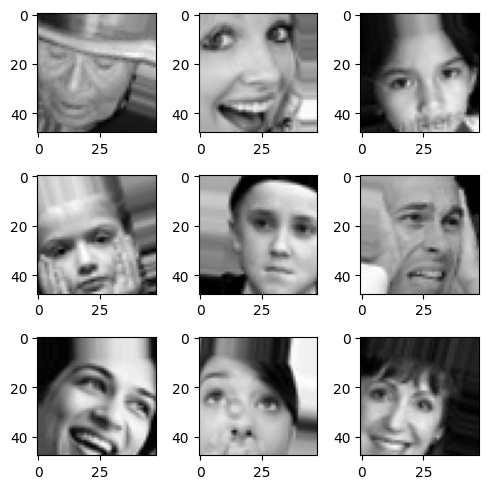

In [ ]:
# training generator
datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.2,1.0),
                                    rescale=1./255,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,)

train_set = datagen_train.flow_from_dataframe(train_df,
                                              folder_path + "train/",
                                              x_col = 'filename',
                                              y_col = 'label',
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)
# view dataloader
show_dataloader_image(train_set)

Found 4977 validated image filenames belonging to 4 classes.


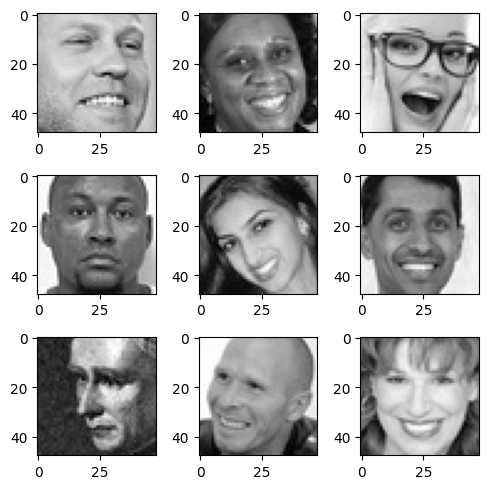

In [ ]:
# validation generator
datagen_test = ImageDataGenerator(rescale=1./255)

validation_set = datagen_test.flow_from_dataframe(validation_df,
                                              folder_path + "validation/",
                                              x_col = 'filename',
                                              y_col = 'label',
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)
# view dataloader
show_dataloader_image(validation_set)

Found 128 validated image filenames belonging to 4 classes.


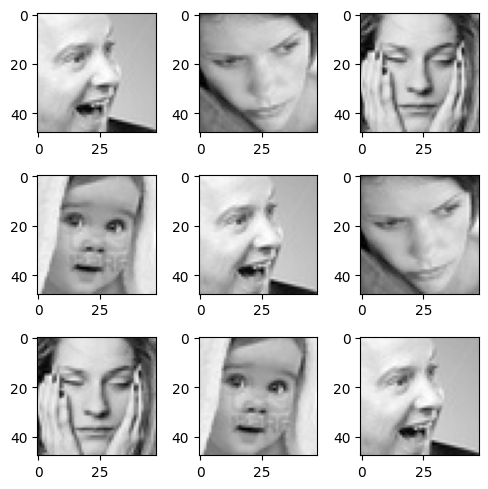

In [ ]:
# testing generator
test_set = datagen_test.flow_from_dataframe(test_df,
                                            folder_path + "test/",
                                            x_col = 'filename',
                                            y_col = 'label',
                                            target_size = (img_size, img_size),
                                            color_mode = 'grayscale',
                                            batch_size = batch_size, 
                                            class_mode='categorical',
                                            shuffle=False)
# view dataloader
show_dataloader_image(test_set)

**RGB data generator**

Found 15109 validated image filenames belonging to 4 classes.


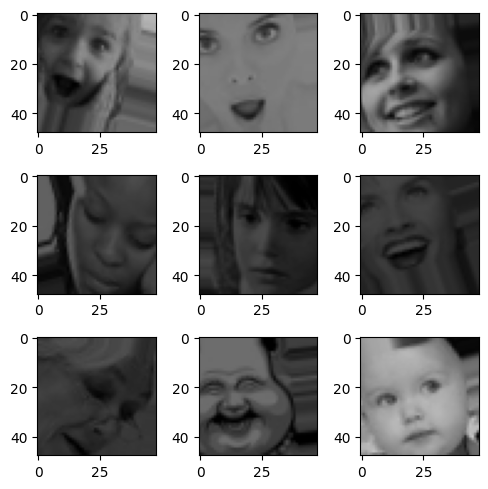

In [ ]:
rgb_train_set = datagen_train.flow_from_dataframe(train_df,
                                              folder_path + "train/",
                                              x_col = 'filename',
                                              y_col = 'label',
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)
# view dataloader
show_dataloader_image(rgb_train_set)

Found 4977 validated image filenames belonging to 4 classes.


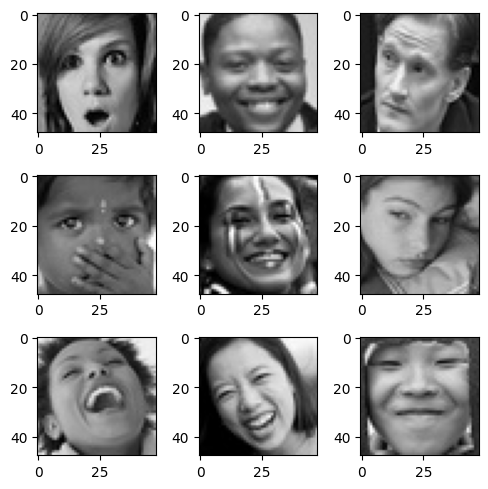

In [ ]:
rgb_validation_set = datagen_test.flow_from_dataframe(validation_df,
                                              folder_path + "validation/",
                                              x_col = 'filename',
                                              y_col = 'label',
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)
# view dataloader
show_dataloader_image(rgb_validation_set)

Found 128 validated image filenames belonging to 4 classes.


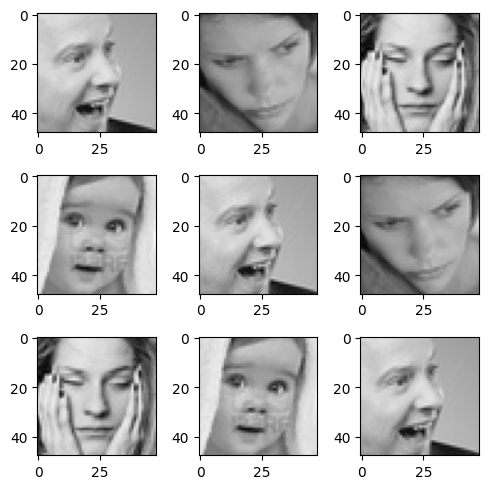

In [ ]:
rgb_test_set = datagen_test.flow_from_dataframe(test_df,
                                            folder_path + "test/",
                                            x_col = 'filename',
                                            y_col = 'label',
                                            target_size = (img_size, img_size),
                                            color_mode = 'rgb',
                                            batch_size = batch_size, 
                                            class_mode='categorical',
                                            shuffle=False)
# view dataloader
show_dataloader_image(rgb_test_set)

<a name="base-neural-network-in-gray-mode"></a>
#### **Base Neural Network in Gray Mode**

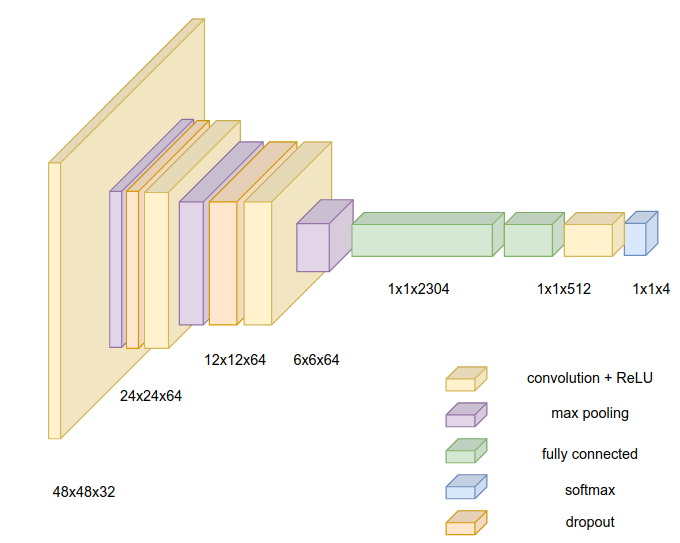

**Callback functions**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, reduce_learningrate]

epochs = 20

**Gray Model**

In [ ]:
def cnn_model_1():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  return model

In [ ]:
# model 1
model_1 = cnn_model_1()
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history_model_1 = model_1.fit(train_set, epochs=epochs, validation_data=validation_set, callbacks=callbacks_list, verbose=1)

Epoch 1/20
473/473 [==============================] - 23s 43ms/step - loss: 1.2380 - accuracy: 0.4255 - val_loss: 1.1552 - val_accuracy: 0.5009 - lr: 1.0000e-04
Epoch 2/20
473/473 [==============================] - 19s 41ms/step - loss: 1.2266 - accuracy: 0.4343 - val_loss: 1.1860 - val_accuracy: 0.4812 - lr: 1.0000e-04
Epoch 3/20
473/473 [==============================] - 21s 43ms/step - loss: 1.2187 - accuracy: 0.4434 - val_loss: 1.1360 - val_accuracy: 0.5180 - lr: 1.0000e-04
Epoch 4/20
473/473 [==============================] - 19s 41ms/step - loss: 1.2098 - accuracy: 0.4415 - val_loss: 1.0853 - val_accuracy: 0.5363 - lr: 1.0000e-04
Epoch 5/20
473/473 [==============================] - 21s 44ms/step - loss: 1.1913 - accuracy: 0.4571 - val_loss: 1.0848 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoch 6/20
473/473 [==============================] - 19s 40ms/step - loss: 1.1801 - accuracy: 0.4646 - val_loss: 1.1507 - val_accuracy: 0.5150 - lr: 1.0000e-04
Epoch 7/20
473/473 [==============

<a name="base-neural-network-in-rgb-mode"></a>
#### **Base Neural Network in RGB Mode**

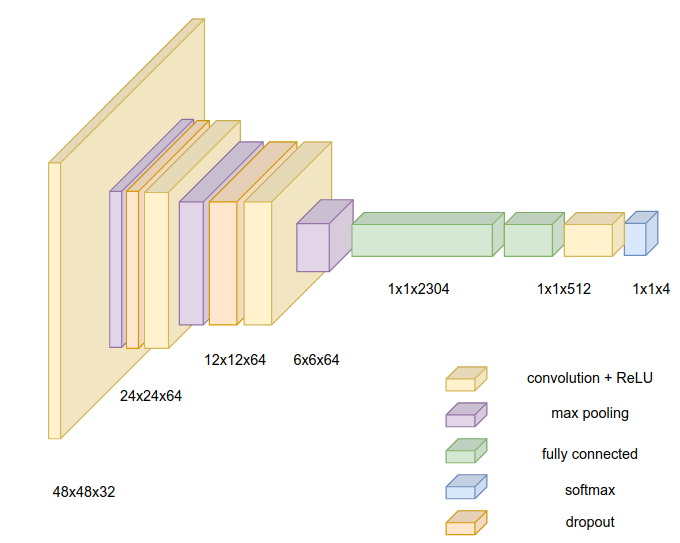

In [ ]:
def cnn_model_2():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  return model

In [ ]:
# model 2
model_2 = cnn_model_2()
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)       

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history_model_2 = model_2.fit(rgb_train_set, epochs=epochs, validation_data=rgb_validation_set, callbacks=callbacks_list, verbose=1)

Epoch 1/20
473/473 [==============================] - 37s 74ms/step - loss: 1.3809 - accuracy: 0.2814 - val_loss: 1.3768 - val_accuracy: 0.2733 - lr: 1.0000e-04
Epoch 2/20
473/473 [==============================] - 35s 73ms/step - loss: 1.3661 - accuracy: 0.3038 - val_loss: 1.3690 - val_accuracy: 0.2833 - lr: 1.0000e-04
Epoch 3/20
473/473 [==============================] - 42s 89ms/step - loss: 1.3601 - accuracy: 0.3156 - val_loss: 1.3461 - val_accuracy: 0.3456 - lr: 1.0000e-04
Epoch 4/20
473/473 [==============================] - 28s 60ms/step - loss: 1.3491 - accuracy: 0.3343 - val_loss: 1.2972 - val_accuracy: 0.4115 - lr: 1.0000e-04
Epoch 5/20
473/473 [==============================] - 29s 61ms/step - loss: 1.3357 - accuracy: 0.3449 - val_loss: 1.2736 - val_accuracy: 0.4057 - lr: 1.0000e-04
Epoch 6/20
473/473 [==============================] - 38s 80ms/step - loss: 1.3253 - accuracy: 0.3586 - val_loss: 1.2567 - val_accuracy: 0.4043 - lr: 1.0000e-04
Epoch 7/20
473/473 [==============

<a name="evaluating-the-base-neural-network"></a>
#### **Evaluating the base neural network**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

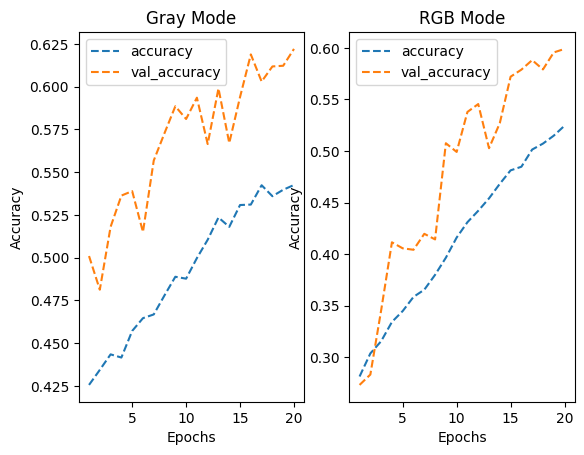

In [ ]:
fig, (ax1, ax2)  = plt.subplots(1, 2)

dict_hist_1 = history_model_1.history
dict_hist_2 = history_model_2.history

list_ep_1 = [i for i in range(1, len(dict_hist_1['accuracy']) + 1)]
list_ep_2 = [i for i in range(1, len(dict_hist_2['accuracy']) + 1)]

ax1.set_title('Gray Mode')
ax1.plot(list_ep_1, dict_hist_1['accuracy'], ls = '--', label = 'accuracy')
ax1.plot(list_ep_1, dict_hist_1['val_accuracy'], ls = '--', label = 'val_accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.set_title('RGB Mode')
ax2.plot(list_ep_2, dict_hist_2['accuracy'], ls = '--', label = 'accuracy')
ax2.plot(list_ep_2, dict_hist_2['val_accuracy'], ls = '--', label = 'val_accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.legend()

plt.show()

Predict on Gray Mode
4/4 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        32
           1       0.47      0.56      0.51        32
           2       0.56      0.16      0.24        32
           3       0.70      0.81      0.75        32

    accuracy                           0.59       128
   macro avg       0.58      0.59      0.55       128
weighted avg       0.58      0.59      0.55       128


Predict on RGB Mode
4/4 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

           0       0.53      0.78      0.63        32
           1       0.53      0.53      0.53        32
           2       0.38      0.09      0.15        32
           3       0.66      0.84      0.74        32

    accuracy                           0.56       128
   macro avg       0.52      0.56      0.51       128
weighted avg       0.52      0.56      

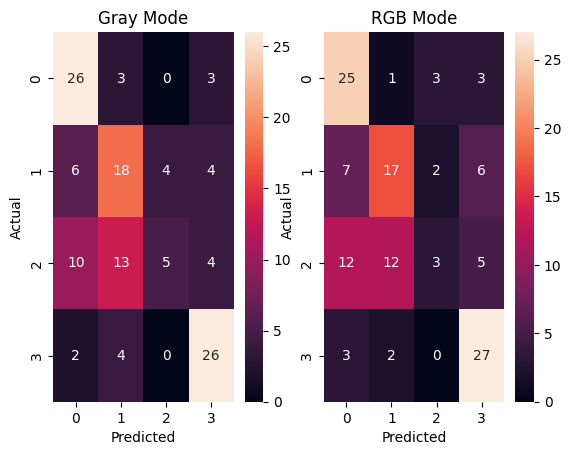

In [ ]:
print('Predict on Gray Mode')

test_pred_1 = model_1.predict(test_set)
test_pred_1 = np.argmax(test_pred_1, axis = -1)

y_true_labels_1 = test_set.classes
   
print(classification_report(y_true_labels_1, test_pred_1))

print()
print('Predict on RGB Mode')

test_pred_2 = model_2.predict(rgb_test_set)
test_pred_2 = np.argmax(test_pred_2, axis = -1)

y_true_labels_2 = rgb_test_set.classes
   
print(classification_report(y_true_labels_2, test_pred_2))

fig, ax  = plt.subplots(1, 2)

cm_1 = confusion_matrix(y_true_labels_1, test_pred_1)
cm_2 = confusion_matrix(y_true_labels_2, test_pred_2)

sns.heatmap(cm_1, annot = True,  fmt = '.0f', ax=ax[0])
sns.heatmap(cm_2, annot = True,  fmt = '.0f', ax=ax[1])

ax[0].set_title('Gray Mode')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

ax[1].set_title('RGB Mode')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()


**Observations and Insights:**

- Gray mode:
    - accuracy: 59%
    - highest F1-scores: class '0' and '3'

- RGB mode:
    - accuracy: 56%
    - highest F1-scores: class '3'

- The model performs slightly better on the gray mode, especially for detecting happiness and surprise

- However, the difference in performance between the two modes is not significant

- Gray mode can achieve more batter performance may due to gray mode reduces the complexity of the image

<a name="transfer-learning"></a>
### **Transfer Learning**

- [VGG16](#vgg16)
- [ResNet v2](#resnet-v2)
- [Efficient Net](#efficient-net)



In [ ]:
import tensorflow as tf

<a name="vgg16"></a>
#### **VGG16**

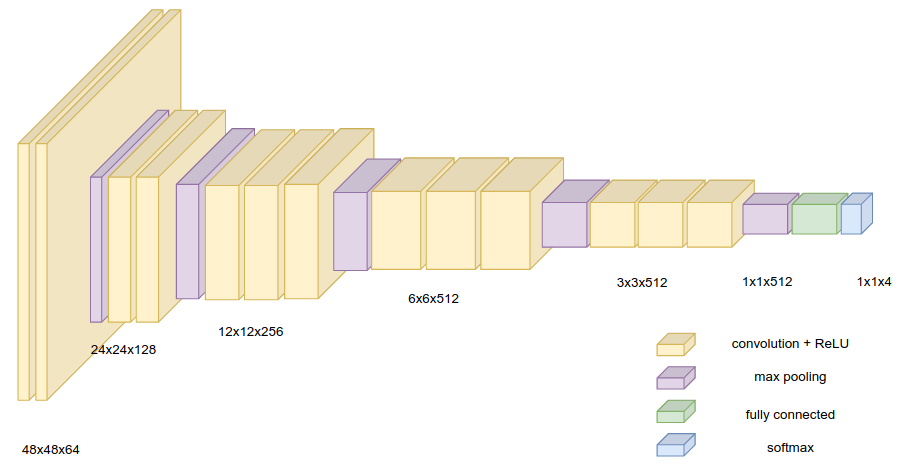

[1]

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = tf.keras.layers.Flatten()(vgg16.output)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

vgg_model = tf.keras.models.Model(inputs=vgg16.input, outputs=output)
vgg_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
vgg_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_history = vgg_model.fit(rgb_train_set, epochs=epochs, validation_data=rgb_validation_set, callbacks=callbacks_list, verbose=1)


Epoch 1/20
473/473 [==============================] - 41s 77ms/step - loss: 1.3556 - accuracy: 0.2865 - val_loss: 1.2390 - val_accuracy: 0.3380 - lr: 5.0000e-04
Epoch 2/20
473/473 [==============================] - 37s 78ms/step - loss: 1.1933 - accuracy: 0.4106 - val_loss: 1.1204 - val_accuracy: 0.5073 - lr: 5.0000e-04
Epoch 3/20
473/473 [==============================] - 37s 79ms/step - loss: 1.0261 - accuracy: 0.5367 - val_loss: 0.8810 - val_accuracy: 0.6110 - lr: 5.0000e-04
Epoch 4/20
473/473 [==============================] - 36s 75ms/step - loss: 0.9109 - accuracy: 0.6000 - val_loss: 0.8481 - val_accuracy: 0.6389 - lr: 5.0000e-04
Epoch 5/20
473/473 [==============================] - 35s 73ms/step - loss: 0.8571 - accuracy: 0.6306 - val_loss: 0.7910 - val_accuracy: 0.6637 - lr: 5.0000e-04
Epoch 6/20
473/473 [==============================] - 38s 79ms/step - loss: 0.8085 - accuracy: 0.6629 - val_loss: 0.6990 - val_accuracy: 0.7125 - lr: 5.0000e-04
Epoch 7/20
473/473 [==============

**Evaluating the VGG16 model**

In [ ]:
def plot_model_history(model_history):
    # Plotting the accuracies
    dict_hist = model_history.history

    list_ep = [i for i in range(1, len(dict_hist['accuracy']) + 1)]

    plt.figure(figsize = (8, 8))

    plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

    plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

    plt.ylabel('Accuracy')

    plt.xlabel('Epochs')

    plt.legend()

    plt.show()


In [ ]:
def check_model_performance(model, testing_data):
    test_pred = model.predict(testing_data)
    test_pred = np.argmax(test_pred, axis = -1)

    y_true_labels = testing_data.classes
    
    print(classification_report(y_true_labels, test_pred))

    cm = confusion_matrix(y_true_labels, test_pred)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f')

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

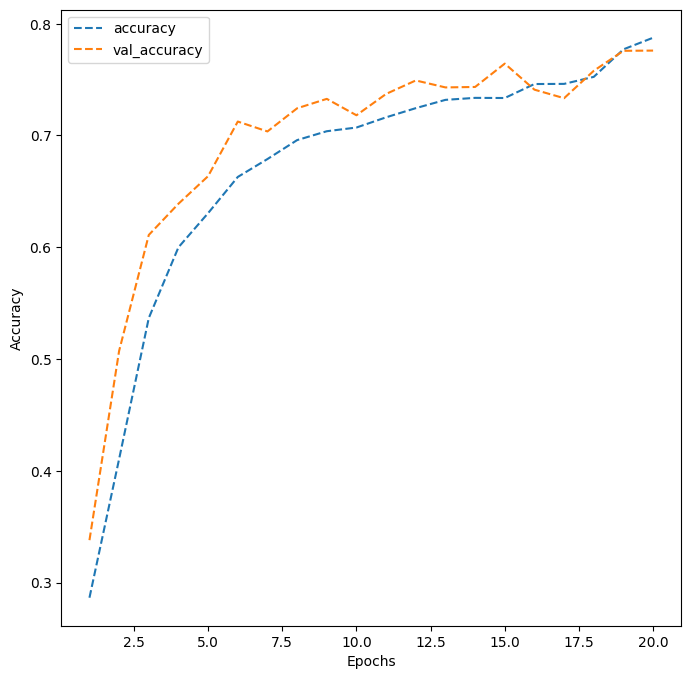

In [ ]:
plot_model_history(vgg_history)

4/4 [==============================] - 0s 32ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.69      0.84      0.76        32
           2       0.72      0.66      0.69        32
           3       1.00      0.88      0.93        32

    accuracy                           0.81       128
   macro avg       0.82      0.81      0.81       128
weighted avg       0.82      0.81      0.81       128



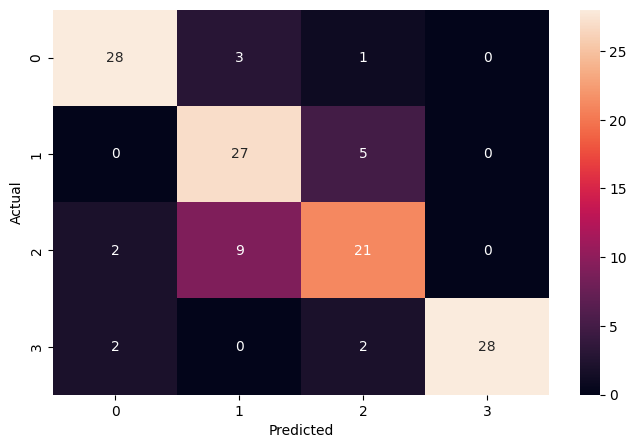

In [ ]:
check_model_performance(vgg_model, rgb_test_set)


**Observations and Insights:**

- The training accuracy is 78.75% and the validation is 77.60%

- The testing accuracy is 81%. The most highest F1-score is class '0' and class '3'. The model classify 'happy' and 'surprise' very well


<a name="resnet-v2"></a>
#### **ResNet V2**

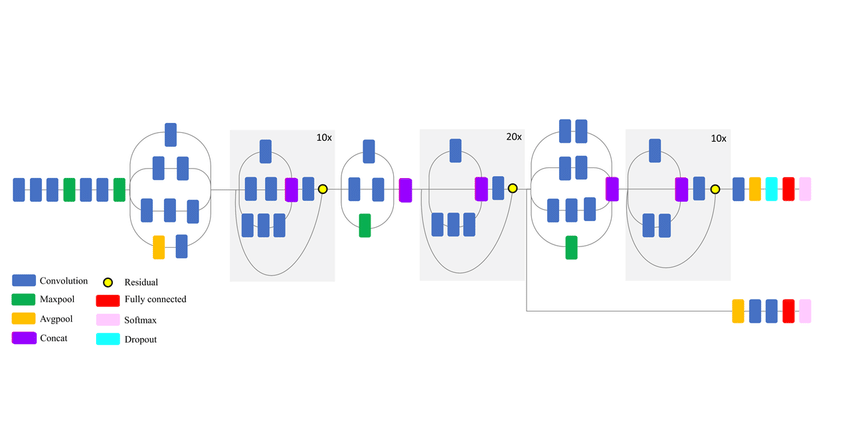

[2]

In [ ]:
resnet152v2 = tf.keras.applications.resnet_v2.ResNet152V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = tf.keras.layers.Flatten()(resnet152v2.output)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

resnet_model = tf.keras.models.Model(inputs=resnet152v2.input, outputs=output)
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet_model.fit(rgb_train_set, epochs=epochs, validation_data=rgb_validation_set, callbacks=callbacks_list, verbose=1)

Epoch 1/20


2023-04-12 09:20:48.468616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-04-12 09:20:49.471932: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-12 09:20:49.474513: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2023-04-12 09:20:49.474548: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-04-12 09:20:49.474637: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 

  1/473 [..............................] - ETA: 11:39:51 - loss: 2.2639 - accuracy: 0.1562

2023-04-12 09:21:34.550564: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


473/473 [==============================] - 172s 176ms/step - loss: 1.3320 - accuracy: 0.3878 - val_loss: 1.2234 - val_accuracy: 0.5604 - lr: 5.0000e-04
Epoch 2/20
473/473 [==============================] - 78s 164ms/step - loss: 1.0318 - accuracy: 0.5655 - val_loss: 9.0198 - val_accuracy: 0.2743 - lr: 5.0000e-04
Epoch 3/20
473/473 [==============================] - 78s 165ms/step - loss: 0.9902 - accuracy: 0.5892 - val_loss: 0.9617 - val_accuracy: 0.5895 - lr: 5.0000e-04
Epoch 4/20
473/473 [==============================] - 78s 164ms/step - loss: 0.8591 - accuracy: 0.6483 - val_loss: 0.7612 - val_accuracy: 0.6986 - lr: 5.0000e-04
Epoch 5/20
473/473 [==============================] - 76s 161ms/step - loss: 0.8538 - accuracy: 0.6504 - val_loss: 0.8944 - val_accuracy: 0.6363 - lr: 5.0000e-04
Epoch 6/20
473/473 [==============================] - 80s 169ms/step - loss: 0.8208 - accuracy: 0.6666 - val_loss: 1.5833 - val_accuracy: 0.5174 - lr: 5.0000e-04
Epoch 7/20
473/473 [==================

**Evaluating the ResNet v2 model**

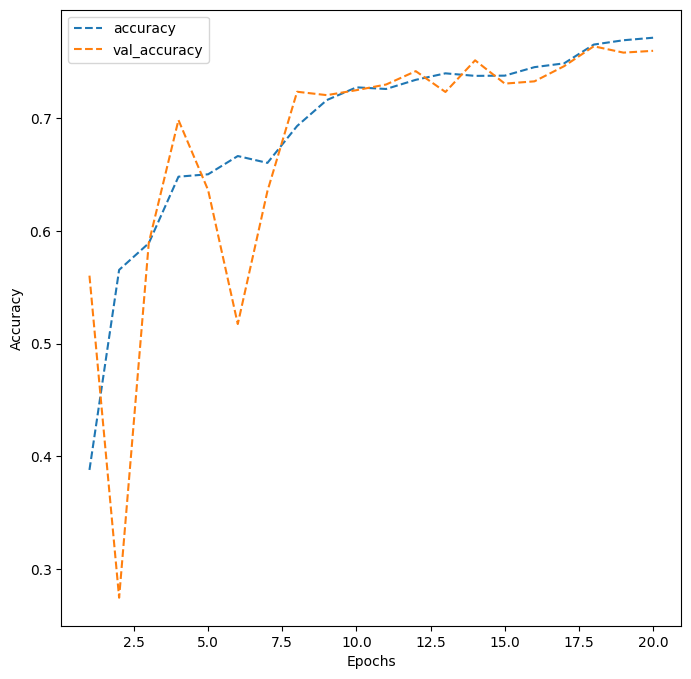

In [ ]:
plot_model_history(resnet_history)

4/4 [==============================] - 3s 48ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.62      0.81      0.70        32
           2       0.74      0.53      0.62        32
           3       0.87      0.84      0.86        32

    accuracy                           0.77       128
   macro avg       0.78      0.77      0.76       128
weighted avg       0.78      0.77      0.76       128



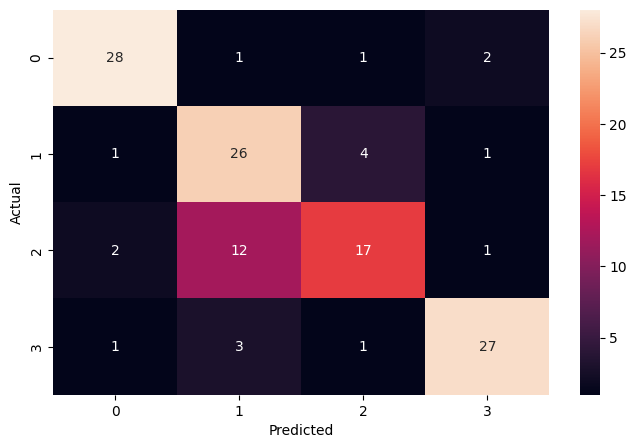

In [ ]:
check_model_performance(resnet_model, rgb_test_set)


**Observations and Insights:**

- The training accuracy is 77.17% and the validation is 60.46%

- The testing accuracy is 76.01%. The most highest F1-score is class '0' and class '3'. The model classify 'happy' and 'surprise' very well


<a name="efficient-net"></a>
#### **Efficient Net**

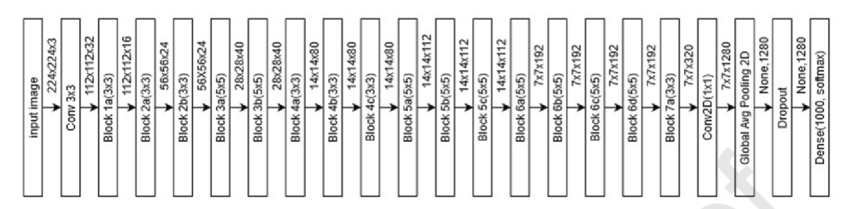

[3]

In [ ]:
efficientnetb0 = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = tf.keras.layers.Flatten()(efficientnetb0.output)
output = Dense(4, activation='softmax')(x)

# Create a new model that includes the modified EfficientNet and the new layers
efficientnet_model = tf.keras.models.Model(inputs=efficientnetb0.input, outputs=output)

efficientnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 48, 48, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 48, 48, 3)   7           ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 48, 48, 3)    0           ['normalization_1[0][0]']  

In [ ]:
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_history = efficientnet_model.fit(rgb_train_set, epochs=epochs, validation_data=rgb_validation_set, callbacks=callbacks_list, verbose=1)

Epoch 1/20
473/473 [==============================] - 115s 98ms/step - loss: 1.3904 - accuracy: 0.3743 - val_loss: 1.5824 - val_accuracy: 0.2086 - lr: 5.0000e-04
Epoch 2/20
473/473 [==============================] - 49s 103ms/step - loss: 1.1686 - accuracy: 0.4812 - val_loss: 1.4504 - val_accuracy: 0.2453 - lr: 5.0000e-04
Epoch 3/20
473/473 [==============================] - 52s 111ms/step - loss: 1.0712 - accuracy: 0.5384 - val_loss: 1.4363 - val_accuracy: 0.2491 - lr: 5.0000e-04
Epoch 4/20
473/473 [==============================] - 43s 91ms/step - loss: 0.9995 - accuracy: 0.5786 - val_loss: 1.5957 - val_accuracy: 0.1706 - lr: 5.0000e-04
Epoch 5/20
473/473 [==============================] - 46s 96ms/step - loss: 0.9484 - accuracy: 0.6070 - val_loss: 1.6900 - val_accuracy: 0.2560 - lr: 5.0000e-04
Epoch 6/20
473/473 [==============================] - 44s 93ms/step - loss: 0.9022 - accuracy: 0.6220 - val_loss: 1.2471 - val_accuracy: 0.4276 - lr: 5.0000e-04
Epoch 7/20
473/473 [===========

**Evaluating the EfficientnetNet Model**

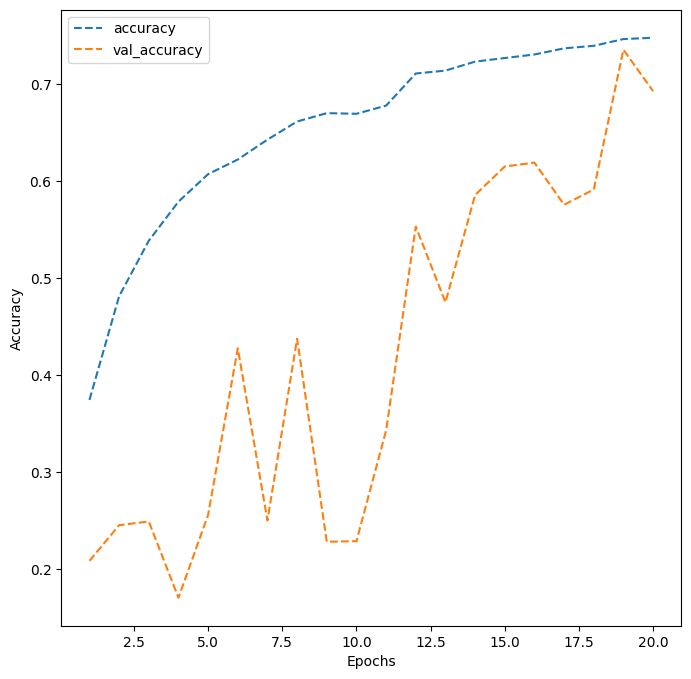

In [ ]:
plot_model_history(efficientnet_history)

4/4 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        32
           1       0.49      0.78      0.60        32
           2       0.80      0.50      0.62        32
           3       0.82      0.56      0.67        32

    accuracy                           0.66       128
   macro avg       0.71      0.66      0.66       128
weighted avg       0.71      0.66      0.66       128



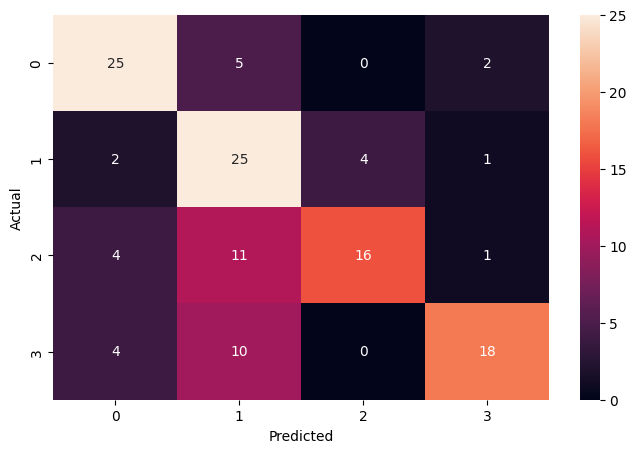

In [ ]:
check_model_performance(efficientnet_model, rgb_test_set)


**Observations and Insights:**

- The training accuracy is 74.75% and the validation is 69.24%

- The testing accuracy is 66%. The most highest F1-score is class '0'. The model classify 'happy' very well. 


<a name="model-summary"></a>
### **Model Summary**

- The performance of pre-trained model better than custom built model
  - Already been trained on large amounts of data
  - Not requiring as much training data or compute resources as a custom model
  
- Compare VGG16, ResNet v2, Efficient Net, VGG16 has the better performance
  - VGG16 is a relatively simple CNN architecture
  - ResNet is a complex CNN architectur that is based on the idea of residual learning.
  - EfficientNet is a new CNN architecture, it is designed to be more computationally efficient than other architectures, while still achieving high accuracy
  - ResNet and EfficientNet can achieve high accuracy on large and complex datasets

- However, pre-trained model performance may worst than custom built model
  - With small dataset, pre-trained models are typically trained on large datasets

  - Domain specific task such as medical images, the visual characteristics and features of medical images are different

<a name="complex-neural-network"></a>
### **Complex Neural Network**

The per-trained model result that the VGG16 model can achieve the most highest accuracy, but the input of the image should be rgb channel. Grayscale input can help to get the efficienct result due to it only has one channle. Therefore, our custom built model combine input of the image is grayscale and VGG16 architecture.

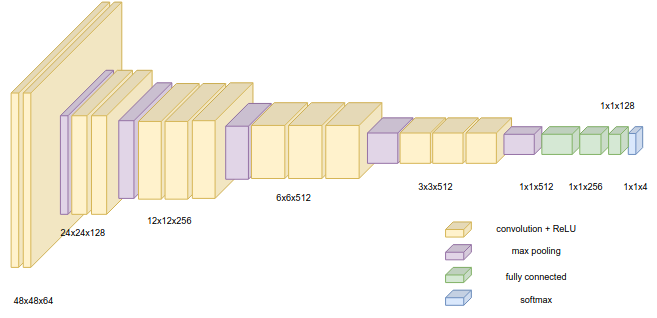

In [ ]:
def complex_cnn_model():
  model = Sequential()

  # Block 1
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1), name="conv1_1"))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name="conv1_2"))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_1"))

  # Block 2
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_1"))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_2"))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_2"))

  # Block 3
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_1"))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_2"))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_3"))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_3"))

  # Block 4
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_1"))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_2"))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_3"))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_4"))

  # Block 5
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv5_1"))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv5_2"))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv5_3"))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_5"))

  # Fully connected layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu', name="fc_1"))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation='relu', name="fc_3"))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu', name="fc_4"))
  model.add(Dropout(0.25))
  model.add(Dense(4, activation='softmax'))

  return model

In [ ]:
# model 3
model_3 = complex_cnn_model()
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2_1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 24, 24, 128)       147584    
                                                                 
 m_pooling2d_2 (MaxPooling2D  (None, 12, 12, 128)      0         
 )                                                    

In [ ]:
model_3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history_model_3 = model_3.fit(train_set, epochs=epochs, validation_data=validation_set, callbacks=callbacks_list, verbose=1)

Epoch 1/20
473/473 [==============================] - 33s 58ms/step - loss: 1.3836 - accuracy: 0.2594 - val_loss: 1.3770 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 2/20
473/473 [==============================] - 28s 59ms/step - loss: 1.3780 - accuracy: 0.2662 - val_loss: 1.3759 - val_accuracy: 0.3739 - lr: 1.0000e-04
Epoch 3/20
473/473 [==============================] - 28s 60ms/step - loss: 1.3744 - accuracy: 0.2759 - val_loss: 1.3632 - val_accuracy: 0.2289 - lr: 1.0000e-04
Epoch 4/20
473/473 [==============================] - 27s 58ms/step - loss: 1.3714 - accuracy: 0.2848 - val_loss: 1.3643 - val_accuracy: 0.2741 - lr: 1.0000e-04
Epoch 5/20
473/473 [==============================] - 28s 59ms/step - loss: 1.3571 - accuracy: 0.3044 - val_loss: 1.3294 - val_accuracy: 0.3110 - lr: 1.0000e-04
Epoch 6/20
473/473 [==============================] - 27s 58ms/step - loss: 1.2995 - accuracy: 0.3467 - val_loss: 1.3142 - val_accuracy: 0.3619 - lr: 1.0000e-04
Epoch 7/20
473/473 [==============

<a name="evaluating-the-complex-neural-network"></a>
#### **Evaluating the Complex Neural Network**

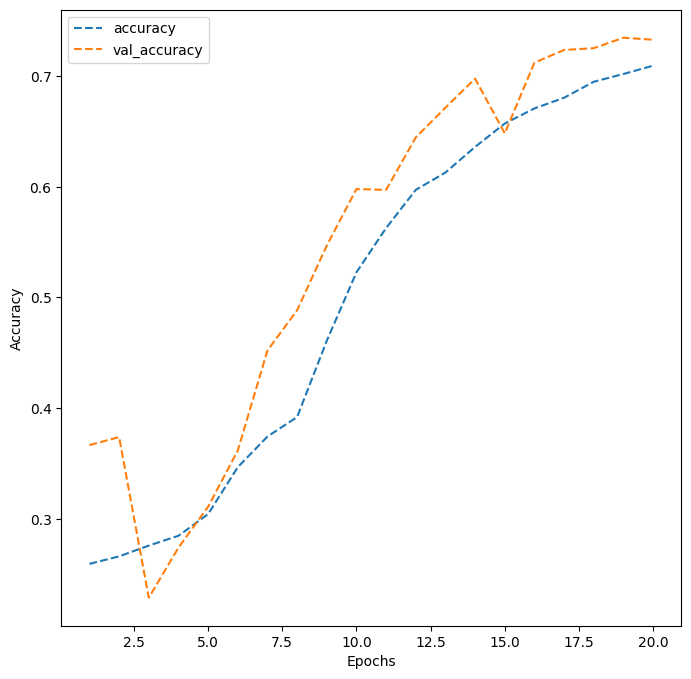

In [ ]:
plot_model_history(history_model_3)

4/4 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.60      0.84      0.70        32
           2       0.75      0.47      0.58        32
           3       0.90      0.84      0.87        32

    accuracy                           0.75       128
   macro avg       0.77      0.75      0.74       128
weighted avg       0.77      0.75      0.74       128



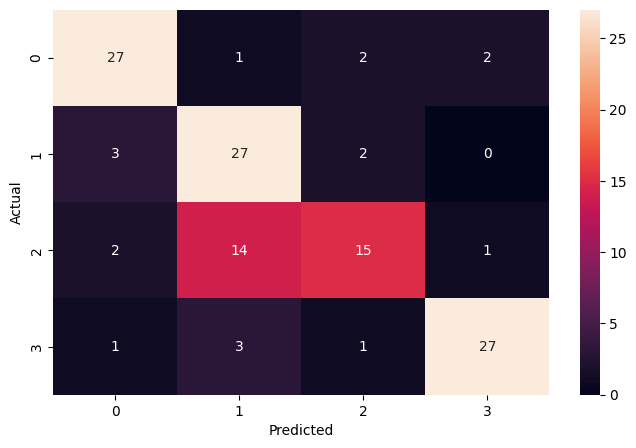

In [ ]:
check_model_performance(model_3, test_set)

<a name="complex-neural-network-observations"></a>
##### **Observations and Insights:**

- the training accuracy is 70.93% and validation accuracy is 73.28%
- the model has an overall accuracy of 75% in test set
- there are any imbalances in the model's performance, the model is better at correctly classifying samples for 0 and 3 classes
- class '2' has the worst result, only have 58% accuracy

<a name="executive-summary"></a>
### **Executive summary**

- What are the most important findings from the analysis done in Milestone - Provide the final proposed model specifications

- Form the above result shows that pre-train model can get a not bad result with small training epochs, but the model easily overfitting
- Both VGG16 and ResNet v2 shows the testing accuracy >75%
- Also tested a non-trained 5-block CNN model can achieve accuracy of 75% in test data. We can improve the model base on the 5-block CNN
- However, all of the model shows that they can classify class '0' and '3' very good, but class '1' and '2' have the lower accuracy

<a name="final-model"></a>
## **Final Model**

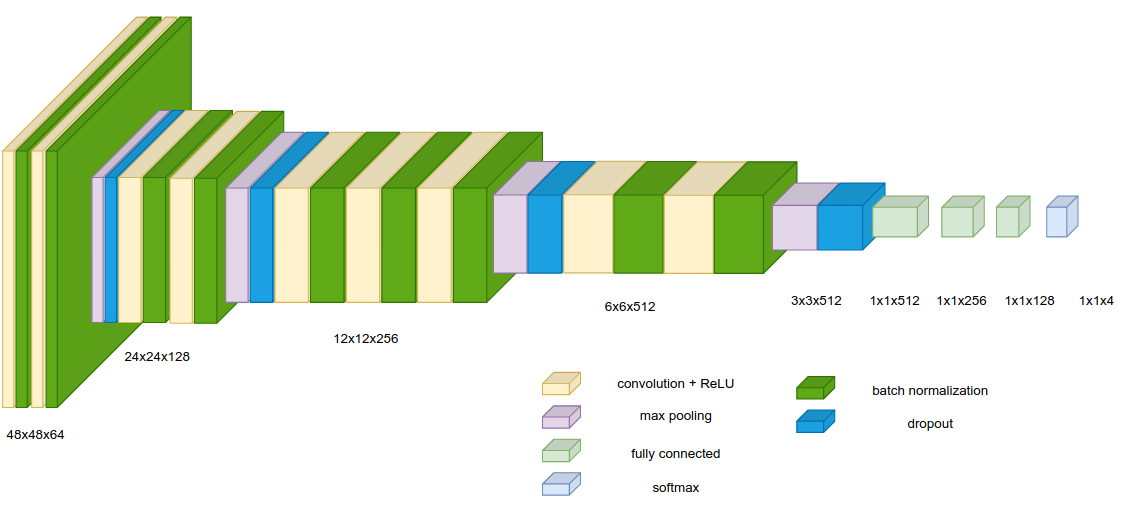

- Tried to train around the pre-trained model and found the model will overfitting when increase training epochs

- Tried 5 block CNN and tune some layer and found the model can be reduce a block of CNN and add dropout and batch normalization to model

- Reasons for choosing the final Architecture
  - batch normalization to the model can prevent the "internal covariate shift" problem, where the distribution of inputs to each layer changes during training, making it harder for the network to learn
  - dropout can prevent overfitting by forcing the network to learn more robust features that are not dependent on any single neuron
    
- Intuitions behind it's better performance than the rest
    
  - apply data clearning, such as remove wrong data and outlier data
  - increase dataset if possible 
  - tune the learning rate
  - increase epochs of training 

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks_list = [
    early_stopping,
    reduce_learningrate,
]

epochs = 60

In [ ]:
 def plot_model_history(model_history):
    # Plotting the accuracies
    dict_hist = model_history.history

    list_ep = [i for i in range(1, len(dict_hist['accuracy']) + 1)]

    plt.figure(figsize = (8, 8))

    plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

    plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

    plt.ylabel('Accuracy')

    plt.xlabel('Epochs')

    plt.legend()

    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def check_model_performance(model, testing_data):
    test_pred = model.predict(testing_data)
    test_pred = np.argmax(test_pred, axis = -1)

    y_true_labels = testing_data.classes
    
    print(classification_report(y_true_labels, test_pred))

    cm = confusion_matrix(y_true_labels, test_pred)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f')

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

### **Model Building**

In [ ]:
def cnn_4_block_model():
  model = Sequential()

  # Block 1
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1), name="conv1_1"))
  model.add(BatchNormalization(name='batchnorm_1'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name="conv1_2"))
  model.add(BatchNormalization(name='batchnorm_2'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_1"))
  model.add(Dropout(0.4, name='dropout_1'))
  
  # Block 2
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_1"))
  model.add(BatchNormalization(name='batchnorm_3'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2_2"))
  model.add(BatchNormalization(name='batchnorm_4'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_2"))
  model.add(Dropout(0.4, name='dropout_2'))

  # Block 3
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_1"))
  model.add(BatchNormalization(name='batchnorm_5'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_2"))
  model.add(BatchNormalization(name='batchnorm_6'))
  model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv3_3"))
  model.add(BatchNormalization(name='batchnorm_7'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_3"))
  model.add(Dropout(0.4, name='dropout_3'))

  # Block 4
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_1"))
  model.add(BatchNormalization(name='batchnorm_8'))
  model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name="conv4_2"))
  model.add(BatchNormalization(name='batchnorm_9'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name="m_pooling2d_4"))
  model.add(Dropout(0.4, name='dropout_4'))
    
  # Fully connected layers
  model.add(GlobalAveragePooling2D()) 
  model.add(Dense(512, activation='relu', name="fc_1"))
  model.add(Dropout(0.5, name='dropout_5'))
  model.add(Dense(256, activation='relu', name="fc_2"))
  model.add(Dropout(0.6, name='dropout_6'))
  model.add(Dense(128, activation='relu', name="fc_3"))
  model.add(Dropout(0.6, name='dropout_7'))
  model.add(Dense(4, activation='softmax', name='output'))

  return model

In [ ]:
model_4 = cnn_4_block_model()
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
model_4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history_model_4 = model_4.fit(train_set,
                    validation_data=validation_set,
                    callbacks=callbacks_list,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)


Epoch 1/60


2023-04-12 04:41:08.474219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


473/473 [==============================] - 37s 64ms/step - loss: 1.6462 - accuracy: 0.2563 - val_loss: 1.3663 - val_accuracy: 0.3669 - lr: 1.0000e-04
Epoch 2/60
473/473 [==============================] - 28s 60ms/step - loss: 1.4362 - accuracy: 0.2526 - val_loss: 1.3587 - val_accuracy: 0.3486 - lr: 1.0000e-04
Epoch 3/60
473/473 [==============================] - 29s 61ms/step - loss: 1.4088 - accuracy: 0.2662 - val_loss: 1.3607 - val_accuracy: 0.3526 - lr: 1.0000e-04
Epoch 4/60
473/473 [==============================] - 24s 50ms/step - loss: 1.4023 - accuracy: 0.2620 - val_loss: 1.3697 - val_accuracy: 0.2749 - lr: 1.0000e-04
Epoch 5/60
473/473 [==============================] - 27s 57ms/step - loss: 1.3947 - accuracy: 0.2663 - val_loss: 1.3665 - val_accuracy: 0.3649 - lr: 1.0000e-04
Epoch 6/60
473/473 [==============================] - 29s 61ms/step - loss: 1.3927 - accuracy: 0.2714 - val_loss: 1.3636 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoch 7/60
473/473 [=========================

### **Evaluating the Model on Test Set**

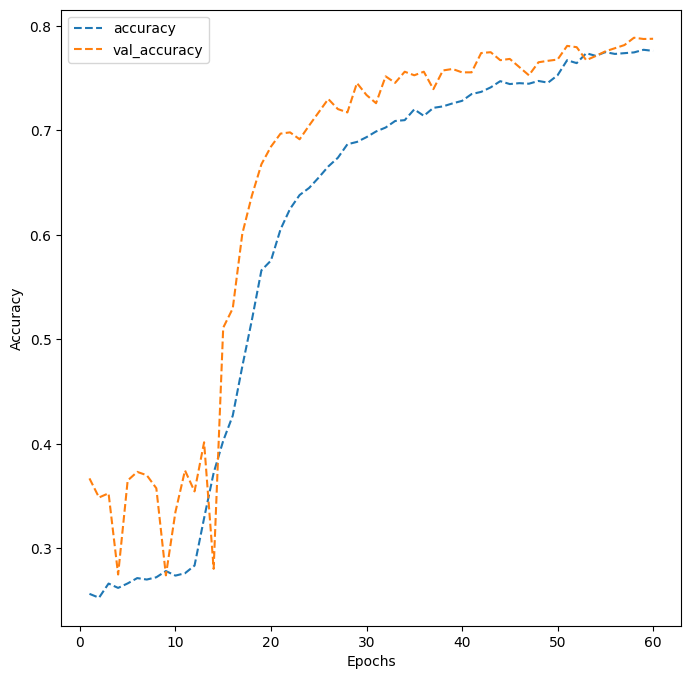

In [ ]:
# Plotting the accuracies
plot_model_history(history_model_4)

4/4 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.65      0.88      0.75        32
           2       0.75      0.56      0.64        32
           3       0.97      0.88      0.92        32

    accuracy                           0.79       128
   macro avg       0.80      0.79      0.79       128
weighted avg       0.80      0.79      0.79       128



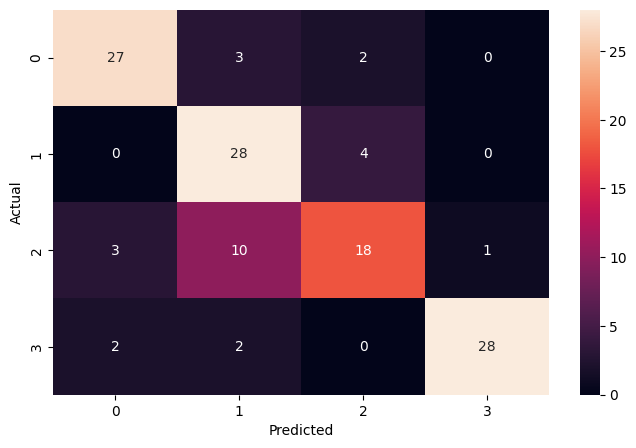

In [ ]:
check_model_performance(model_4, test_set)

<a name="5-convolutional-blocks"></a>
**Observations and Insights:**

- the training accuracy is 77.62% and validation accuracy is 78.78%
- the modle slightly overfitting 
- the model has an overall accuracy of 79% in test set
- there are any imbalances in the model's performance, the model is better at correctly classifying samples for 0 and 3 classes
- the results are similar to the VGG16 model

### **Set class weight**

**set class '1' and '2' to 3**

In [ ]:
model_5 = cnn_4_block_model()
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                      

In [ ]:
class_weight = {0: 1, 1: 3, 2: 3, 3: 1}

In [ ]:
model_5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history_model_5 = model_5.fit(train_set,
                    validation_data=validation_set,
                    callbacks=callbacks_list,
                    epochs=50,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/50


2023-04-12 05:58:52.716215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


473/473 [==============================] - 32s 53ms/step - loss: 3.2370 - accuracy: 0.2639 - val_loss: 1.5300 - val_accuracy: 0.2285 - lr: 1.0000e-04
Epoch 2/50
473/473 [==============================] - 27s 56ms/step - loss: 2.7377 - accuracy: 0.2627 - val_loss: 1.5606 - val_accuracy: 0.2429 - lr: 1.0000e-04
Epoch 3/50
473/473 [==============================] - 26s 56ms/step - loss: 2.6672 - accuracy: 0.2617 - val_loss: 1.4935 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 4/50
473/473 [==============================] - 26s 55ms/step - loss: 2.6334 - accuracy: 0.2667 - val_loss: 1.4652 - val_accuracy: 0.2455 - lr: 1.0000e-04
Epoch 5/50
473/473 [==============================] - 27s 57ms/step - loss: 2.6068 - accuracy: 0.2672 - val_loss: 1.5079 - val_accuracy: 0.2377 - lr: 1.0000e-04
Epoch 6/50
473/473 [==============================] - 27s 56ms/step - loss: 2.5923 - accuracy: 0.2653 - val_loss: 1.5040 - val_accuracy: 0.2367 - lr: 1.0000e-04
Epoch 7/50
473/473 [=========================

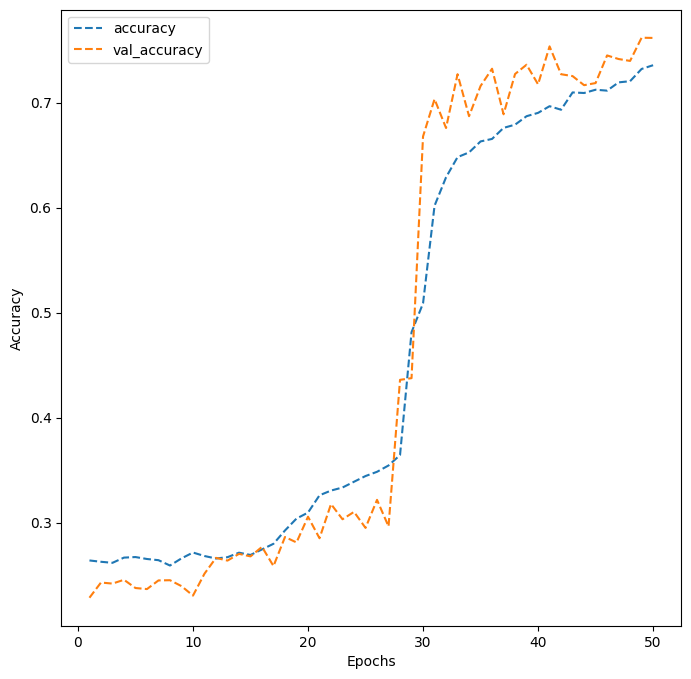

In [ ]:
# Plotting the accuracies
plot_model_history(history_model_5)

    

4/4 [==============================] - 0s 32ms/step
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.66      0.91      0.76        32
           2       0.84      0.66      0.74        32
           3       0.93      0.84      0.89        32

    accuracy                           0.81       128
   macro avg       0.83      0.81      0.81       128
weighted avg       0.83      0.81      0.81       128



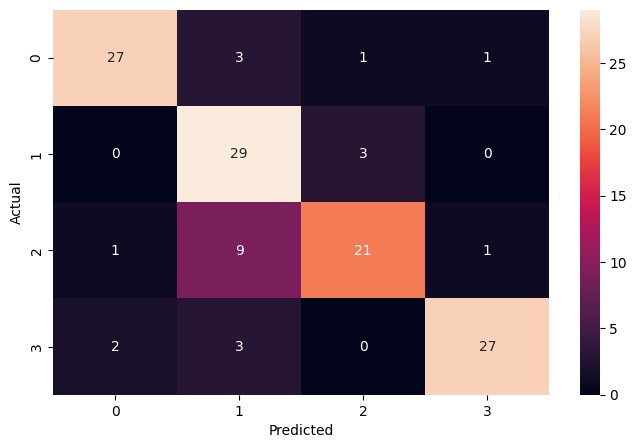

In [ ]:
check_model_performance(model_5, test_set)

**set class '1' and '2' to 4**

In [ ]:
model_6 = cnn_4_block_model()
model_6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                      

In [ ]:
class_weight = {0: 1, 1: 4, 2: 4, 3: 1}

In [ ]:
model_6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history_model_6 = model_6.fit(train_set,
                    validation_data=validation_set,
                    callbacks=callbacks_list,
                    epochs=80,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/80


2023-04-12 07:35:00.919233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


473/473 [==============================] - 36s 60ms/step - loss: 4.0587 - accuracy: 0.2581 - val_loss: 1.5654 - val_accuracy: 0.2443 - lr: 1.0000e-04
Epoch 2/80
473/473 [==============================] - 27s 58ms/step - loss: 3.3308 - accuracy: 0.2685 - val_loss: 1.6282 - val_accuracy: 0.2473 - lr: 1.0000e-04
Epoch 3/80
473/473 [==============================] - 27s 57ms/step - loss: 3.2202 - accuracy: 0.2663 - val_loss: 1.5622 - val_accuracy: 0.2520 - lr: 1.0000e-04
Epoch 4/80
473/473 [==============================] - 27s 57ms/step - loss: 3.1406 - accuracy: 0.2722 - val_loss: 1.5159 - val_accuracy: 0.2566 - lr: 1.0000e-04
Epoch 5/80
473/473 [==============================] - 28s 58ms/step - loss: 3.1360 - accuracy: 0.2643 - val_loss: 1.5834 - val_accuracy: 0.2495 - lr: 1.0000e-04
Epoch 6/80
473/473 [==============================] - 26s 55ms/step - loss: 3.1104 - accuracy: 0.2649 - val_loss: 1.5705 - val_accuracy: 0.2363 - lr: 1.0000e-04
Epoch 7/80
473/473 [=========================

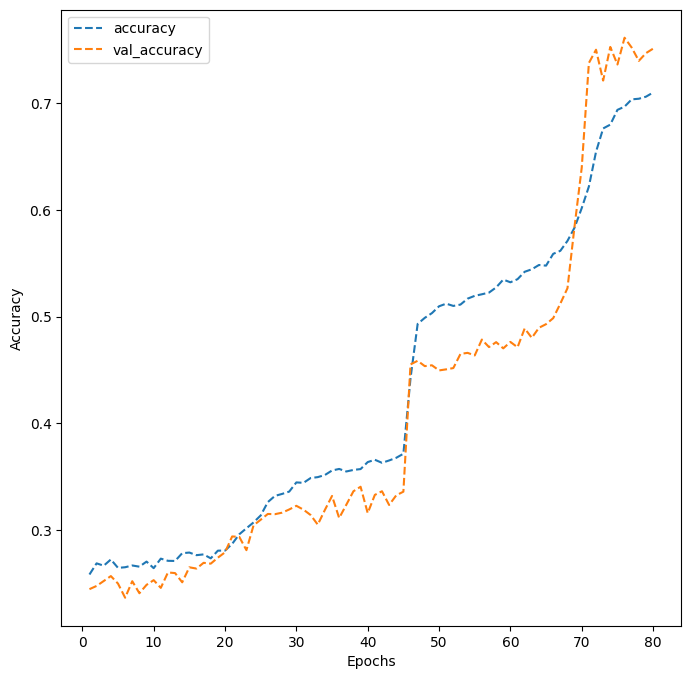

In [ ]:
# Plotting the accuracies
plot_model_history(history_model_6)

4/4 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.68      0.81      0.74        32
           2       0.73      0.75      0.74        32
           3       0.93      0.81      0.87        32

    accuracy                           0.80       128
   macro avg       0.82      0.80      0.81       128
weighted avg       0.82      0.80      0.81       128



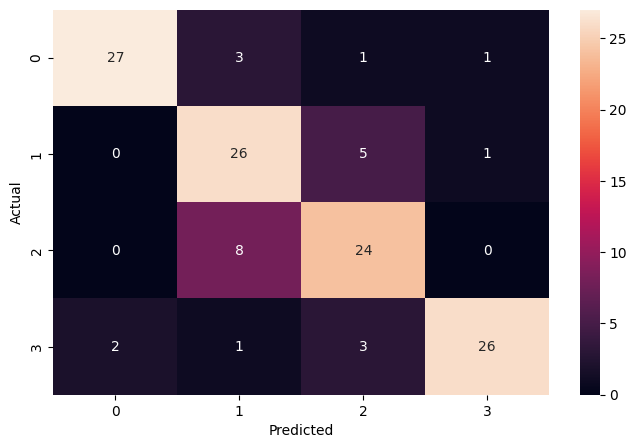

In [ ]:
check_model_performance(model_6, test_set)

**set class '1' and '2' to 3.5**

In [ ]:
model_7 = cnn_4_block_model()
model_7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 m_pooling2d_1 (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                      

In [ ]:
class_weight = {0: 1, 1: 3.5, 2: 3.5, 3: 1}

In [ ]:
model_7.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history_model_7 = model_7.fit(train_set,
                    validation_data=validation_set,
                    callbacks=callbacks_list,
                    epochs=80,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/80


2023-04-12 06:58:32.763044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


473/473 [==============================] - 32s 54ms/step - loss: 3.5718 - accuracy: 0.2596 - val_loss: 1.5314 - val_accuracy: 0.2443 - lr: 1.0000e-04
Epoch 2/80
473/473 [==============================] - 28s 60ms/step - loss: 3.0095 - accuracy: 0.2690 - val_loss: 1.4327 - val_accuracy: 0.2465 - lr: 1.0000e-04
Epoch 3/80
473/473 [==============================] - 26s 55ms/step - loss: 2.9293 - accuracy: 0.2653 - val_loss: 1.5342 - val_accuracy: 0.2405 - lr: 1.0000e-04
Epoch 4/80
473/473 [==============================] - 27s 58ms/step - loss: 2.8931 - accuracy: 0.2618 - val_loss: 1.5357 - val_accuracy: 0.2439 - lr: 1.0000e-04
Epoch 5/80
473/473 [==============================] - 26s 54ms/step - loss: 2.8583 - accuracy: 0.2672 - val_loss: 1.5095 - val_accuracy: 0.2445 - lr: 1.0000e-04
Epoch 6/80
473/473 [==============================] - 27s 56ms/step - loss: 2.8453 - accuracy: 0.2674 - val_loss: 1.5074 - val_accuracy: 0.2445 - lr: 1.0000e-04
Epoch 7/80
473/473 [=========================

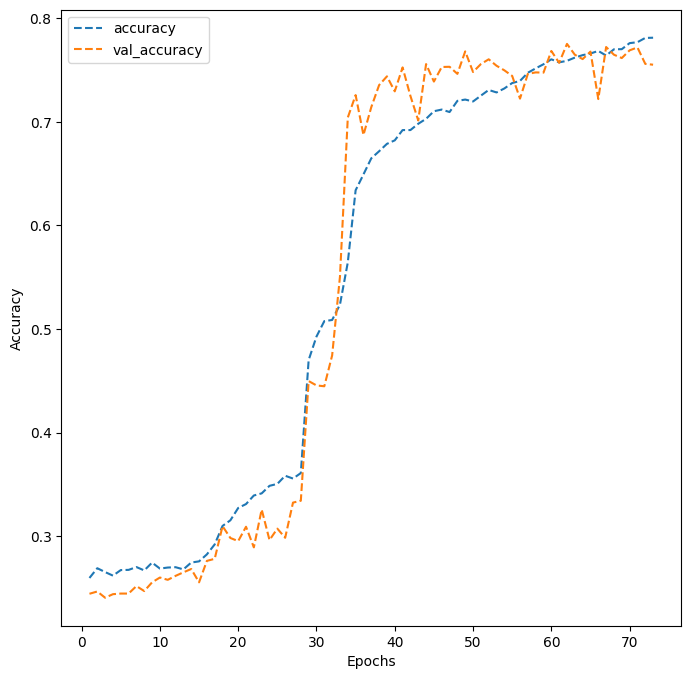

In [ ]:
# Plotting the accuracies
plot_model_history(history_model_7)

4/4 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        32
           1       0.68      0.84      0.75        32
           2       0.73      0.69      0.71        32
           3       0.96      0.84      0.90        32

    accuracy                           0.81       128
   macro avg       0.83      0.81      0.82       128
weighted avg       0.83      0.81      0.82       128



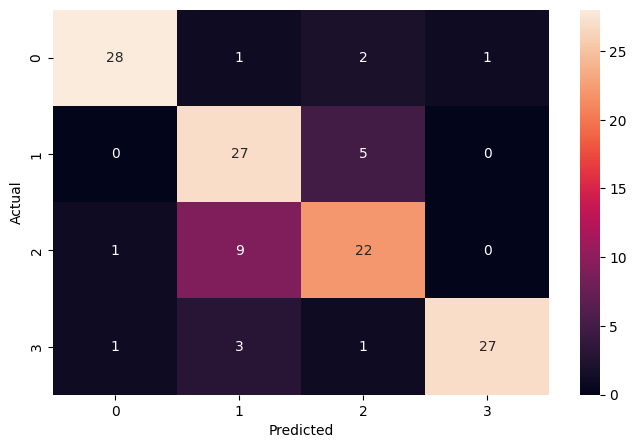

In [ ]:
check_model_performance(model_7, test_set)

**Observations and Insights:**
- After set the class weight, the result of classify class '1' and '2' improved
- Compare above three models, the weight of class '1' and '2' set to 3.5 is the best model

<a name="summary"></a>
### **Summary**

- compare to pre-trained model and custom built model
  - pre-trained model only need to train with small epochs and get not bad performance
  
- Intuitions behind it's better performance than the rest
    - apply data clearning, such as remove wrong data and outlier data
    - increase dataset if possible 
    - tune the dropout param

<a name="problem-and-solution-summary"></a>
### **Problem and solution summary**

**Summary of the problem**
  - Both of the models, even pre-trained model or custom built are week on classify between sad and neutral

**Explain the reason for the proposed solution design**
  - Set the class weights. By assigning higher weights to the classes, the model will try to improve its performance on those classes

**How it would affect the problem/business?**
  - If the sad and neutral emotion confused could have negative effects on the problem depending on how the model is being used. Improving the accuracy of these classes could lead to more accurate and useful insights. Such as:
    - customer service: the chatbot unable to accurately identify when a customer is frustrated or satisfied


<a name="recommendations-for-implementation"></a>
### **Recommendations for implementation**
**What are some key recommendations to implement the solutions?**
- For custom built model, we need to find a stable model first. Such as add more neural network, tune dropout layers parameter.
- Tune the class weights in the model
- Train the model and evaluate the model
  
- For pre-trained model, we can fine tune the model for training, such as freeze some of the layer
- Train the model and evaluate the model

**What are the key actionables for stakeholders? What is the expected benefit and/or costs?**
- Cost
    - Implement data augmentation techniques to balance the number of examples across classes and improve the model's ability to generalize to new data
    - Experinent with different model architectures or hyperparameters and evaluate their performance on a validation set
    - Consider using transfer learning, which involves using a pre-trained model as a starting point and fine-tuning it on the specific task
    - Conduct additional analysis to ensure that the model is not introducing bias and that its predictions are interpretable and aligned with the stakeholders' goals

- Benefit
    - Improve the accuracy of the model for classes 1 and 2, which currently have lower accuracy
    - Improve the overall accuracy of the model
    - Improve performance and faster convergence.
    - Increased trust and confidence in the model's predictions.

**What are the key risks and challenges?**
- the key pattern between sad and neutral are similar 
- sad and neutral emotion is difficult to recognize
- imbalanced dataset may affect the result

**What further analysis needs to be done or what other associated problems need to be solved?**
- It become a specific model when we set class weight in this situation. Becuase the training sample of sad and neutral is more than happy and surprise, Therefore, if the number of sample are the same, the model may have biased. 
- Increasing the data size may help to solve problem, but we can also use other algorithm for multi model to improve the result


[1] Max Ferguson, Ronay Ak, Yung-Tsun Tina Lee, Kincho H. Law 
"Automatic Localization of Casting Defects with 
Convolutional Neural Networks, 2017"

[2] Masoud Mahdianpari, Bahram Salehi, Mohammad Rezaee, 
Fariba Mohammadimanesh, Yun Zhang
"Very Deep Convolutional Neural Networks for Complex Land Cover Mapping Using Multispectral Remote Sensing Imagery, 2018"

[3] Karar Ali, Abdullah Ayub Khan, Asif Ali Laghari, Zaffar Ahmed Shaikh
"Multiclass Skin Cancer Classification using EfficientNets -A First Step towards Preventing Skin Cancer, 2021"